In [24]:
%matplotlib inline
import seaborn as sns

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## 5. Dataset 6 : Dutch Emission

### 5.1 Baca Berkas

In [4]:
emission = pd.read_csv("greenhouse-gas-emissions-in-the-netherlands/emission.csv", delimiter=';')

In [5]:
emission.head()

ID    Bronnen  Perioden   CO2_1    CH4_2  N2O_3
0   0  T001176    1990JJ00  163120  1278.17  59.49
1   1  T001176    1995JJ00  173520  1192.41  59.84
2   2  T001176    2000JJ00  172290   975.64  53.01
3   3  T001176    2001JJ00  177390   949.16  49.71
4   4  T001176    2002JJ00  176670   904.27  47.01

Karena ditemui bahwa bahasa yang digunakan adalah dalam penamaan tabel adalah dari bahasa belanda, maka akan kita ubah terlebih dahulu menjadi bahasa Inggris untuk memudahkan pengerjaan nantinya.

In [6]:
emission = emission.rename(columns={'Bronnen' : 'Sources', 'Perioden' : 'Periods'})
# src : https://translate.google.com/#view=home&op=translate&sl=nl&tl=en&text=Perioden%0ABronnen

# Cek ulang, untuk melihat perubahan
emission.head()

ID    Sources   Periods   CO2_1    CH4_2  N2O_3
0   0  T001176    1990JJ00  163120  1278.17  59.49
1   1  T001176    1995JJ00  173520  1192.41  59.84
2   2  T001176    2000JJ00  172290   975.64  53.01
3   3  T001176    2001JJ00  177390   949.16  49.71
4   4  T001176    2002JJ00  176670   904.27  47.01

### 5.2 Visualisasi Data

Dalam dataset ini, ada beberapa hal yang bisa disajikan, yaitu

#### 5.2.1. CO2

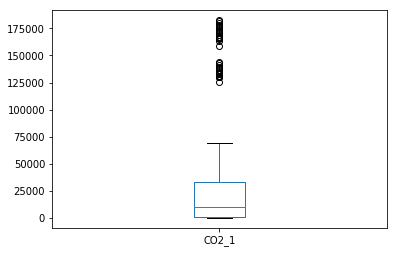

In [7]:
emission['CO2_1'].plot.box()

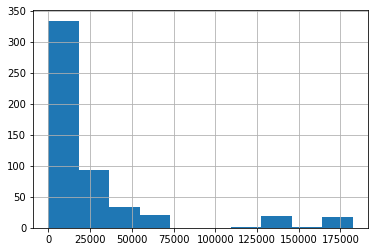

In [8]:
emission['CO2_1'].hist()

#### 5.2.2 CH4

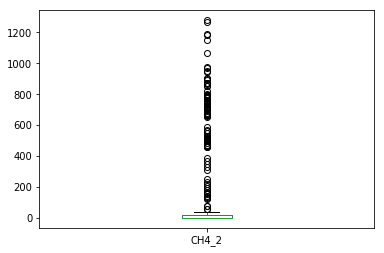

In [9]:
emission['CH4_2'].plot.box()

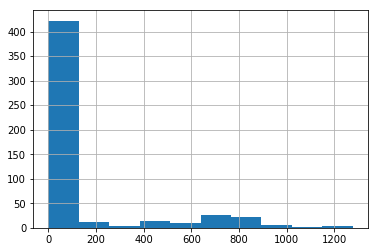

In [10]:
emission['CH4_2'].hist()

#### 5.2.3 N2O

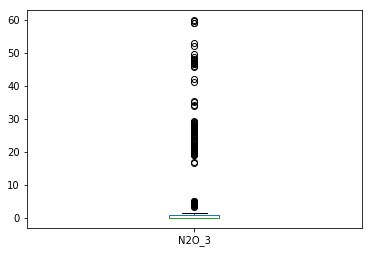

In [11]:
emission['N2O_3'].plot.box()

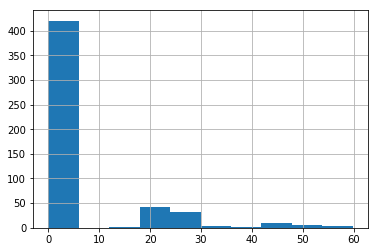

In [12]:
emission['N2O_3'].hist()

### 5.3 Deskripsi Statistik Data

Dalam dataset ini, ada beberapa hal yang bisa disajikan, yaitu
#### 5.3.1. CO2

In [13]:
print("=== CO2 ===")
print("Minimum Value      :", emission['CO2_1'].min())
print("Maximum Value      :", emission['CO2_1'].max())
print("Mean               :", emission['CO2_1'].mean())
print("Mode               :", emission['CO2_1'].mode()[0])
print("Variance           :", emission['CO2_1'].var())
print("Standard Deviation :", emission['CO2_1'].std())
print("Skewness           :", emission['CO2_1'].skew())
print("Kurtosis           :", emission['CO2_1'].kurt())

=== CO2 ===
Minimum Value      : 30
Maximum Value      : 182440
Mean               : 25673.01923076923
Mode               : 40
Variance           : 1664567682.7741964
Standard Deviation : 40799.11374986222
Skewness           : 2.47848175690753
Kurtosis           : 5.59745217324895


#### 5.3.2. CH4

In [14]:
print("=== CH4 ===")
print("Minimum Value      :", emission['CH4_2'].min())
print("Maximum Value      :", emission['CH4_2'].max())
print("Mean               :", emission['CH4_2'].mean())
print("Mode               :", emission['CH4_2'].mode()[0])
print("Variance           :", emission['CH4_2'].var())
print("Standard Deviation :", emission['CH4_2'].std())
print("Skewness           :", emission['CH4_2'].skew())
print("Kurtosis           :", emission['CH4_2'].kurt())

=== CH4 ===
Minimum Value      : 0.0
Maximum Value      : 1278.17
Mean               : 129.60303846153846
Mode               : 0.0
Variance           : 76324.83079807174
Standard Deviation : 276.2694894447661
Skewness           : 2.1214621623998107
Kurtosis           : 3.2850095587948065


#### 5.3.3. N2O

In [15]:
print("=== N2O ===")
print("Minimum Value      :", emission['N2O_3'].min())
print("Maximum Value      :", emission['N2O_3'].max())
print("Mean               :", emission['N2O_3'].mean())
print("Mode               :", emission['N2O_3'].mode()[0])
print("Variance           :", emission['N2O_3'].var())
print("Standard Deviation :", emission['N2O_3'].std())
print("Skewness           :", emission['N2O_3'].skew())
print("Kurtosis           :", emission['N2O_3'].kurt())

=== N2O ===
Minimum Value      : 0.0
Maximum Value      : 59.84
Mean               : 5.987807692307693
Mode               : 0.03
Variance           : 153.34271503038389
Standard Deviation : 12.383162561736153
Skewness           : 2.261290161593164
Kurtosis           : 4.607188144519335


### 5.4 Menentukan Fungsi Densitas Probabilitas

Dengan melihat bentuk dari histogram pada subbab 5.2, kami akan mencoba mencocokan plot distribusi dari ke-3 nya dengan distribusi Gamma.

#### 5.4.1 CO2

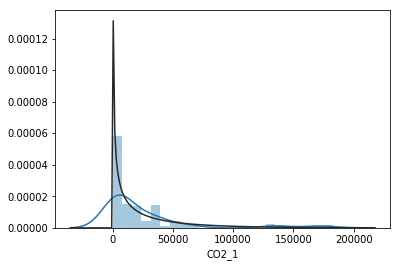

In [16]:
from scipy.stats import gamma

sns.distplot(emission['CO2_1'], fit=gamma)

#### 5.4.2 CH4

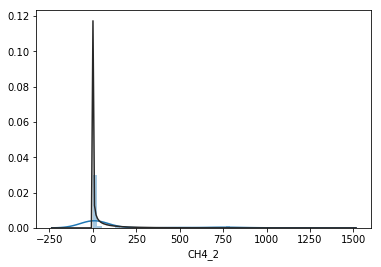

In [17]:
sns.distplot(emission['CH4_2'], fit=gamma)

#### 5.4.3 N2O

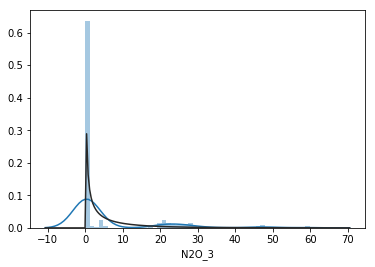

In [18]:
sns.distplot(emission['N2O_3'],fit=gamma)

c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg wa

TypeError: '<=' not supported between instances of 'int' and 'str'

<Figure size 864x576 with 0 Axes>

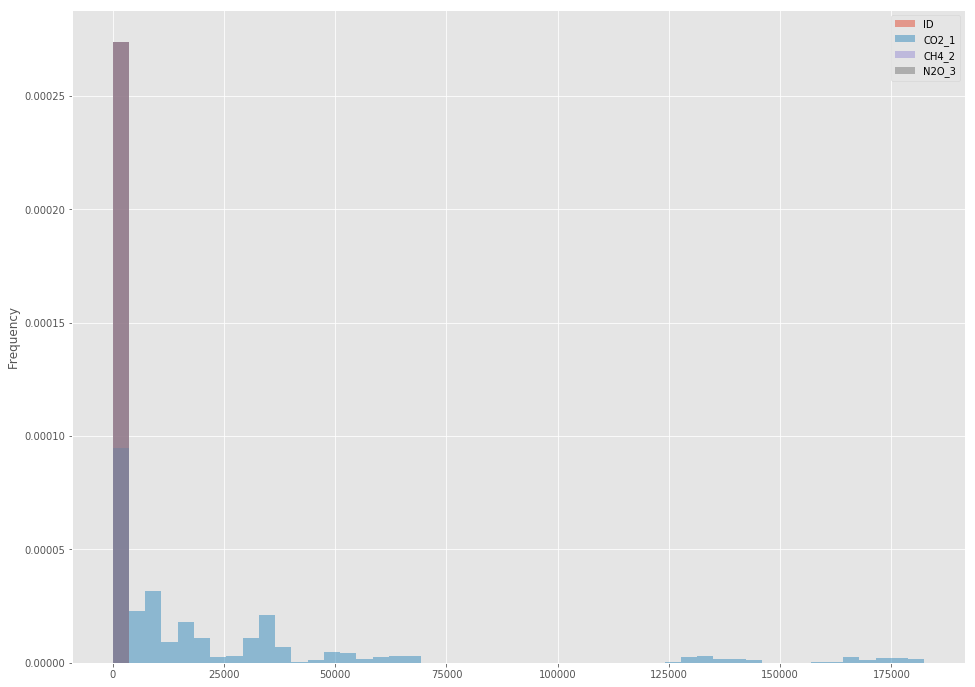

In [30]:
# Load data from statsmodels datasets
data = emission

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
print(best_fit_name)
# best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

### 5.5 Pertanyaan

Nyonya Meneer adalah seorang Environmentalist dari Belanda. Beliau sedang menyelidiki bagaimana efek dari emisi gas rumah kaca karbon dioksida, metana dan dinitrogen oksida di negara Belanda. Beliau adalah seseorang tidak suka dengan pemanasan global yang melanda dunia ini. Tentu beliau tidak ingin belanda tenggelam, karena sudah dibawah permukaan laut, lalu ditambah dengan pencairan es kutub utara. Beliau menyelidiki ini setiap tahun dengan 20 sektor. Tentu beliau ingin menentukan pola emisi gas rumah kaca tersebut dan memprediksinya. Maka, beliau harus menentukan ini terlebih dahulu.
1. Dalam 10 tahun, untuk menyelamatkan bumi dari pemanasan global membutuhkan total emisi dari karbon dioksida, metana dan dinitrogen oksida tidak lebih dari 12000, 600, 25. Sebutkan ekspektasi total (untuk sektor T001176) emisi dari karbon dioksida, metana dan dinitrogen oksida menyebabkan pemanasan global!

2. Dalam 6 tahun:
    1. Ekspektasi emisi dari sektor ekstraksi minyak bumi (sektor 305800) untuk rata-rata semua emisi gas tidak lebih dari 1500
    2. Ekspektasi emisi dari sektor perusahaan energi (sektor 346700) untuk rata-rata semua emisi gas tidak lebih dari 35000
    
3. *Confidence Interval 90%*

### 5.6 Jawaban

In [19]:
# Simplifikasi data dengan mengelompokkan data berdasar sectornya
emission_by_sector = emission.groupby(['Sources']).sum().reset_index()
emission_by_sector

Sources     ID    CO2_1     CH4_2   N2O_3
0   1050010     4590   396230    401.32    6.01
1   301100      5390   152770  10160.16  473.59
2   305800      1390    35990    410.26    0.32
3   320300      1790   226730     19.65    0.71
4   320705      2990   350300    356.59  248.85
5   328100      3390   137830      6.85    0.56
6   346700      2190   992220    381.31    8.98
7   350000      4190    14570      1.42    0.00
8   800044       990  1254960    811.27   10.00
9   800045      2590   682170    396.89  250.31
10  800051      4990   366370  15266.72  495.25
11  A025421     6190   736810     72.54   18.34
12  A025422     6590   651900     65.71   16.94
13  A025423     6990     1960      0.17    0.00
14  A025424     7390   629590     63.00   16.38
15  A025425     7790    19400      2.58    0.51
16  A025428     8190      900      0.00    0.00
17  A025429     8590    84940      6.85    1.40
18  A025430     8990    22130      1.27    0.20
19  A025431     9390    16200      1.51    0.45
20  A025432     9790     4060      0.40    0.24
21  A025433    10190    42530      3.63    0.54
22  A025441     3790   179500     32.02    0.94
23  A025446     5790   213610   5106.58   21.65
24  A025447      590  2699740  16876.18  761.59
25  T001176      190  3436560  16948.70  779.90

In [20]:
## Hitung total Karbon Dioksida
CO2_total = emission_by_sector['CO2_1'].sum()
print("Total CO2 \t\t\t=", CO2_total)

## Hitung jumlah Karbon Dioksida pada Sector T001176
CO2_in_sector_1176 = emission_by_sector['CO2_1'].loc[25]
print("Total CO2 in sector T001176 \t=", CO2_in_sector_1176)

## Hitung peluang Karbon Dioksida
CO2_prob = CO2_in_sector_1176/CO2_total
print("Probability of CO2 \t\t=",CO2_prob,'\n')

## Hitung total Metana
CH4_total = emission_by_sector['CH4_2'].sum()
print("Total CH4 \t\t\t=", CH4_total)

## Hitung jumlah Metana pada Sector T001176
CH4_in_sector_1176 = emission_by_sector['CH4_2'].loc[25]
print("Total CH2 in sector T001176 \t=", CH4_in_sector_1176)

## Hitung peluang Metana
CH4_prob = CH4_in_sector_1176/CH4_total
print("Probability of CH4 \t\t=",CH4_prob,'\n')

## Hitung total Dinitrogen Oksida
N2O_total = emission_by_sector['N2O_3'].sum()
print("Total NO2 \t\t\t=", N2O_total)

## Hitung jumlah Dinitrogen Oksida pada Sector T001176
N2O_in_sector_1176 = emission_by_sector['N2O_3'].loc[25]
print("Total N2O in sector T001176 \t=", N2O_in_sector_1176)

## Hitung peluang Dinitrogen Oksida
N2O_prob = N2O_in_sector_1176/N2O_total
print("Probability of N2O \t\t=",N2O_prob,'\n')

Total CO2 			= 13349970
Total CO2 in sector T001176 	= 3436560
Probability of CO2 		= 0.2574208031928162 

Total CH4 			= 67393.58
Total CH2 in sector T001176 	= 16948.7
Probability of CH4 		= 0.2514883465160925 

Total NO2 			= 3113.66
Total N2O in sector T001176 	= 779.8999999999997
Probability of N2O 		= 0.2504769306860736 



In [21]:
## Cari Alpha dan Beta dari masing masing

beta_CO2 = emission['CO2_1'].var()/emission['CO2_1'].mean()
# alpha_CO2 = emission['CO2_1'].mean()/beta_CO2
# print("Alpha CO2 =", alpha_CO2)
print("Beta CO2  =", beta_CO2)
print()

beta_CH4 = emission['CH4_2'].var()/emission['CH4_2'].mean()
alpha_CH4 = emission['CH4_2'].mean()/beta_CH4
print("Alpha CH4 =", alpha_CH4)
print("Beta CH4  =", beta_CH4)
print()

beta_N2O = emission['N2O_3'].var()/emission['N2O_3'].mean()
alpha_N2O = emission['N2O_3'].mean()/beta_N2O
print("Alpha N2O =", alpha_N2O)
print("Beta N2O  =", beta_N2O)
print()

Beta CO2  = 64837.23896327723

Alpha CH4 = 0.22007186131734435
Beta CH4  = 588.9123565627068

Alpha N2O = 0.23381509159372174
Beta N2O  = 25.609158294675595

